<a href="https://colab.research.google.com/github/HARSITHRAM/Interactive-Online-Class/blob/main/Copy_of_emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

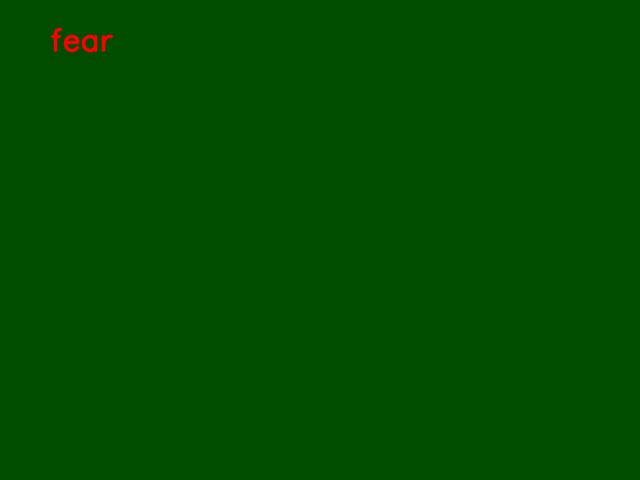

In [ ]:
!pip install paho-mqtt deepface
!wget https://github.com/googlefonts/roboto/raw/main/src/hinted/Roboto-Bold.ttf -O /content/bold.ttf
!apt-get update
!apt-get install -y libfreetype6-dev libpng-dev
!pip install -U Pillow
from google.colab.patches import cv2_imshow # Import for displaying images
from IPython.display import display, clear_output
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
from deepface import DeepFace
from PIL import Image, ImageDraw, ImageFont
import paho.mqtt.client as mqtt
import socket

# Function to convert JavaScript object into OpenCV image
def js_to_image(js_reply):
    """Converts JavaScript object into OpenCV image."""
    print("js_to_image called")
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    print("Image shape:", img.shape)
    return img

# Function to overlay emotion text on an image
def overlay_emotion_text(frame, emotion, position=(50, 50), font_scale=1, thickness=2):
    """Overlays emotion text on the frame."""
    cv2.putText(frame, emotion, position, cv2.FONT_HERSHEY_SIMPLEX,
                font_scale, (0, 0, 255), thickness, cv2.LINE_AA)

# Function to display the video stream (Not used anymore, but kept for context)
def video_stream():
    """Displays the video stream."""
    # This function is not necessary anymore, as we define and call stream_frame
    # directly within eval_js in video_frame.
    pass

# Function to get a video frame
def video_frame(label, bbox):
    """Gets a video frame."""
    # Define and call stream_frame directly within eval_js
    data = eval_js(f'''
        async function stream_frame(label, bbox) {{
            const video = document.createElement('video');
            const canvas = document.createElement('canvas');
            const ctx = canvas.getContext('2d');

            const stream = await navigator.mediaDevices.getUserMedia({{ video: true }});
            video.srcObject = stream;
            await video.play();

            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;

            ctx.drawImage(video, 0, 0, canvas.width, canvas.height);

            const img = canvas.toDataURL('image/jpeg');

            return {{ img }};
        }}
        // The following line was changed to directly call and return the result of the stream_frame function
        // instead of attempting to return from the global scope.
        stream_frame("{label}", "{bbox}");
    ''')  # Call stream_frame here
    print("Video frame received")
    return data

# MQTT setup
broker_address = "b7567dff6628421e8bfca997634b396b.s1.eu.hivemq.cloud"
broker_port = 8883
topic = "your_topic"

# Create a client object using version 1 of the callback API:
client = mqtt.Client(client_id="colab_publisher", protocol=mqtt.MQTTv311)

# Set TLS configuration
client.tls_set()

# Set your HiveMQ Cloud credentials
client.username_pw_set("HARSITHRAM", "Ram@2005")

try:
    client.connect(broker_address, broker_port)
    print("Connected to MQTT broker")
except socket.gaierror as e:
    print(f"Connection error: {e}")
    print("Please check your broker address and network connectivity.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Main execution loop
# video_stream() # No longer needed
label_html = 'Capturing...'
bbox = ''

try:
    while True:
        js_reply = video_frame(label_html, bbox)
        if not js_reply:
            break

        img0 = js_to_image(js_reply["img"])

        try:
            print("Analyzing emotion...")
            objs = DeepFace.analyze(img_path=img0, actions=['emotion'], enforce_detection=False)
            emotion = objs[0]['dominant_emotion']
            print("Detected emotion:", emotion)

            # Check if dominant emotion is in targeted emotions list
            targeted_emotions = ['fear', 'surprise', 'sad']  # 'shocked' replaced with 'surprise'
            if emotion in targeted_emotions:
                print(f"Targeted emotion detected: {emotion}")
                client.publish(topic, emotion)

                # Overlay emotion text on the frame
                overlay_emotion_text(img0, emotion)

            else:
                print(f"Emotion '{emotion}' not in targeted emotions, skipping...")

        except Exception as e:
            print(f"Error during emotion analysis: {e}")

        # Display the frame with overlay
        clear_output(wait=True)  # Clear previous output
        display(PIL.Image.fromarray(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)))

        time.sleep(0.1)  # Adjust delay as needed

except KeyboardInterrupt:
    print("Stopped by user")

finally:
    # Release resources
    cv2.destroyAllWindows()
    print("Process finished.")